# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 16  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 30000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 250     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 7611.68798828125
iteration 0 loss 2427.649169921875


iteration 500 loss 105.9451675415039


iteration 1000 loss 100.54150390625


iteration 1500 loss 97.71177673339844


iteration 2000 loss 94.54105377197266


iteration 2500 loss 90.52095794677734


iteration 3000 loss 85.3809814453125


iteration 3500 loss 78.27371978759766


iteration 4000 loss 66.83058166503906


iteration 4500 loss 43.95144271850586


iteration 5000 loss 15.473429679870605


iteration 5500 loss 5.1653852462768555


iteration 6000 loss 3.066991090774536


iteration 6500 loss 2.492199420928955


iteration 7000 loss 2.073240041732788


iteration 7500 loss 1.7222250699996948


iteration 8000 loss 1.4252084493637085


iteration 8500 loss 1.2271982431411743


iteration 9000 loss 1.1158455610275269


iteration 9500 loss 1.0022481679916382


iteration 10000 loss 0.8868938684463501


iteration 10500 loss 0.7732844948768616


iteration 11000 loss 0.6907391548156738


iteration 11500 loss 0.6638575196266174


iteration 12000 loss 0.634096622467041


iteration 12500 loss 0.5999204516410828


iteration 13000 loss 0.561183750629425


iteration 13500 loss 0.5181401371955872


iteration 14000 loss 0.4714028835296631


iteration 14500 loss 0.4377644658088684


iteration 15000 loss 0.42116808891296387


iteration 15500 loss 0.4022020101547241


iteration 16000 loss 0.3802962899208069


iteration 16500 loss 0.35545381903648376


iteration 17000 loss 0.35661208629608154


iteration 17500 loss 0.32470476627349854


iteration 18000 loss 0.3178654909133911


iteration 18500 loss 0.30974888801574707


iteration 19000 loss 0.2999987006187439


iteration 19500 loss 0.28840306401252747


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.27481865882873535


iteration 20500 loss 0.2731732428073883


iteration 21000 loss 0.27109479904174805


iteration 21500 loss 0.268481969833374


iteration 22000 loss 0.265218049287796


iteration 22500 loss 0.26117467880249023


iteration 23000 loss 0.25620874762535095


iteration 23500 loss 0.2501857578754425


iteration 24000 loss 0.24298390746116638


iteration 24500 loss 0.2345084697008133


iteration 25000 loss 0.22474506497383118


iteration 25500 loss 0.21805647015571594


iteration 26000 loss 0.21434518694877625


iteration 26500 loss 0.20984570682048798


iteration 27000 loss 0.20444200932979584


iteration 27500 loss 0.19803304970264435


iteration 28000 loss 0.19056838750839233


iteration 28500 loss 0.18787118792533875


iteration 29000 loss 0.18575575947761536


iteration 29500 loss 0.18314361572265625


iteration 30000 loss 0.17993971705436707


iteration 30500 loss 0.17604884505271912


iteration 31000 loss 0.17137722671031952


iteration 31500 loss 0.16585642099380493


iteration 32000 loss 0.16351298987865448


iteration 32500 loss 0.1619395911693573


iteration 33000 loss 0.1599835306406021


iteration 33500 loss 0.1575666218996048


iteration 34000 loss 0.15460912883281708


iteration 34500 loss 0.1510249674320221


iteration 35000 loss 0.14674097299575806


iteration 35500 loss 0.14464372396469116


iteration 36000 loss 0.14314720034599304


iteration 36500 loss 0.14129342138767242


iteration 37000 loss 0.13901536166667938


iteration 37500 loss 0.13624078035354614


iteration 38000 loss 0.1329016387462616


iteration 38500 loss 0.1307249367237091


iteration 39000 loss 0.12942451238632202


iteration 39500 loss 0.127809077501297


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.1258135735988617


iteration 40500 loss 0.12556469440460205


iteration 41000 loss 0.12525227665901184


iteration 41500 loss 0.12486064434051514


iteration 42000 loss 0.12437324970960617


iteration 42500 loss 0.1237710565328598


iteration 43000 loss 0.12303436547517776


iteration 43500 loss 0.1221449226140976


iteration 44000 loss 0.12108702212572098


iteration 44500 loss 0.11985055357217789


iteration 45000 loss 0.11843317002058029


iteration 45500 loss 0.11684366315603256


iteration 46000 loss 0.11513286828994751


iteration 46500 loss 0.11364419758319855


iteration 47000 loss 0.11204036325216293


iteration 47500 loss 0.11065997183322906


iteration 48000 loss 0.10913383215665817


iteration 48500 loss 0.1078776866197586


iteration 49000 loss 0.10647406429052353


iteration 49500 loss 0.10520478338003159


iteration 50000 loss 0.10388406366109848


iteration 50500 loss 0.10267467051744461


iteration 51000 loss 0.10143882036209106


iteration 51500 loss 0.10029415786266327


iteration 52000 loss 0.09918594360351562


iteration 52500 loss 0.0979892760515213


iteration 53000 loss 0.09699255973100662


iteration 53500 loss 0.09586498886346817


iteration 54000 loss 0.0948345810174942


iteration 54500 loss 0.09375755488872528


iteration 55000 loss 0.09283755719661713


iteration 55500 loss 0.09194518625736237


iteration 56000 loss 0.09093046188354492


iteration 56500 loss 0.09001637995243073


iteration 57000 loss 0.08907335996627808


iteration 57500 loss 0.0881904810667038


iteration 58000 loss 0.08742519468069077


iteration 58500 loss 0.08654694259166718


iteration 59000 loss 0.08567152917385101


iteration 59500 loss 0.0848969891667366


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.08401303738355637


iteration 60500 loss 0.08391304314136505


iteration 61000 loss 0.08379997313022614


iteration 61500 loss 0.08367470651865005


iteration 62000 loss 0.08353790640830994


iteration 62500 loss 0.08339068293571472


iteration 63000 loss 0.08323491364717484


iteration 63500 loss 0.08307266980409622


iteration 64000 loss 0.08290567994117737


iteration 64500 loss 0.08273553103208542


iteration 65000 loss 0.08256331831216812


iteration 65500 loss 0.08238998055458069


iteration 66000 loss 0.082216277718544


iteration 66500 loss 0.08204247802495956


iteration 67000 loss 0.08186889439821243


iteration 67500 loss 0.0816958025097847


iteration 68000 loss 0.08152367919683456


iteration 68500 loss 0.08135249465703964


iteration 69000 loss 0.08118240535259247


iteration 69500 loss 0.08101341873407364


iteration 70000 loss 0.0808454379439354


iteration 70500 loss 0.08067838847637177


iteration 71000 loss 0.08051233738660812


iteration 71500 loss 0.08034705370664597


iteration 72000 loss 0.08018263429403305


iteration 72500 loss 0.08001910150051117


iteration 73000 loss 0.07985630631446838


iteration 73500 loss 0.0796942487359047


iteration 74000 loss 0.07953307032585144


iteration 74500 loss 0.07937267422676086


iteration 75000 loss 0.07921303808689117


iteration 75500 loss 0.07905402034521103


iteration 76000 loss 0.07889577001333237


iteration 76500 loss 0.07873819768428802


iteration 77000 loss 0.078581303358078


iteration 77500 loss 0.0784251019358635


iteration 78000 loss 0.07826954871416092


iteration 78500 loss 0.07811465114355087


iteration 79000 loss 0.07796049118041992


iteration 79500 loss 0.07780701667070389


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.0776541456580162


iteration 80500 loss 0.07763948291540146


iteration 81000 loss 0.07762469351291656


iteration 81500 loss 0.07760991901159286


iteration 82000 loss 0.07759515941143036


iteration 82500 loss 0.07758031040430069


iteration 83000 loss 0.07756547629833221


iteration 83500 loss 0.07755070179700851


iteration 84000 loss 0.07753587514162064


iteration 84500 loss 0.07752106338739395


iteration 85000 loss 0.07750628143548965


iteration 85500 loss 0.07749149203300476


iteration 86000 loss 0.07747671008110046


iteration 86500 loss 0.07746194303035736


iteration 87000 loss 0.07744718343019485


iteration 87500 loss 0.07743242383003235


iteration 88000 loss 0.07741761207580566


iteration 88500 loss 0.07740294933319092


iteration 89000 loss 0.07738818228244781


iteration 89500 loss 0.07737351208925247


iteration 90000 loss 0.07735884189605713


iteration 90500 loss 0.0773441269993782


iteration 91000 loss 0.07732944190502167


iteration 91500 loss 0.07731477916240692


iteration 92000 loss 0.07730010151863098


iteration 92500 loss 0.07728541642427444


iteration 93000 loss 0.07727076858282089


iteration 93500 loss 0.07725617289543152


iteration 94000 loss 0.07724153995513916


iteration 94500 loss 0.0772269070148468


iteration 95000 loss 0.0772123709321022


iteration 95500 loss 0.07719770818948746


iteration 96000 loss 0.07718309760093689


iteration 96500 loss 0.07716850936412811


iteration 97000 loss 0.07715396583080292


iteration 97500 loss 0.07713934779167175


iteration 98000 loss 0.07712478190660477


iteration 98500 loss 0.07711023837327957


iteration 99000 loss 0.07709567248821259


iteration 99500 loss 0.0770811066031456


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---
loss 102.46380615234375


loss 62.66852569580078


loss 43.46475601196289


loss 34.2870979309082


loss 30.364200592041016


loss 28.93159294128418


loss 28.5117244720459


loss 28.420818328857422


loss 28.407711029052734


loss 28.406606674194336


loss 28.406551361083984


loss 28.40655517578125


loss 28.406557083129883


loss 28.406551361083984


loss 28.40655517578125


loss 28.40655517578125


loss 28.40655517578125


loss 28.40655517578125


loss 28.406553268432617


loss 28.40655517578125


loss 28.406558990478516


loss 28.40655517578125


loss 28.406557083129883


loss 28.406557083129883


loss 28.406557083129883


loss 28.406553268432617


loss 28.406557083129883


loss 28.406557083129883


loss 28.40655517578125


loss 28.40655517578125


loss 28.406558990478516


loss 28.40655517578125


loss 28.406558990478516


loss 28.406557083129883


loss 28.40655517578125


loss 28.406557083129883


loss 28.406558990478516


loss 28.40655517578125


loss 28.406553268432617


loss 28.40655517578125


final mse:  3.458668906830553e-09
max, min: 1.9924961 -2.0663702
loss 102.46380615234375


loss 63.361854553222656


loss 45.27119064331055


loss 36.942100524902344


loss 33.474796295166016


loss 32.22175216674805


loss 31.85211944580078


loss 31.770217895507812


loss 31.7579345703125


loss 31.756834030151367


loss 31.75678253173828


loss 31.756776809692383


loss 31.756784439086914


loss 31.75678253173828


loss 31.75678253173828


loss 31.756776809692383


loss 31.75678062438965


loss 31.756786346435547


loss 31.756778717041016


loss 31.75678062438965


loss 31.756776809692383


loss 31.75678253173828


loss 31.75678062438965


loss 31.756778717041016


loss 31.75678253173828


loss 31.756778717041016


loss 31.75678253173828


loss 31.756778717041016


loss 31.75678253173828


loss 31.756778717041016


loss 31.75678253173828


loss 31.75678253173828


loss 31.75678253173828


loss 31.75678253173828


loss 31.75678253173828


loss 31.756778717041016


loss 31.75678253173828


loss 31.756778717041016


loss 31.75678253173828


loss 31.756776809692383


final mse:  3.2647249348372043e-09
max, min: 1.967817 -2.0251057


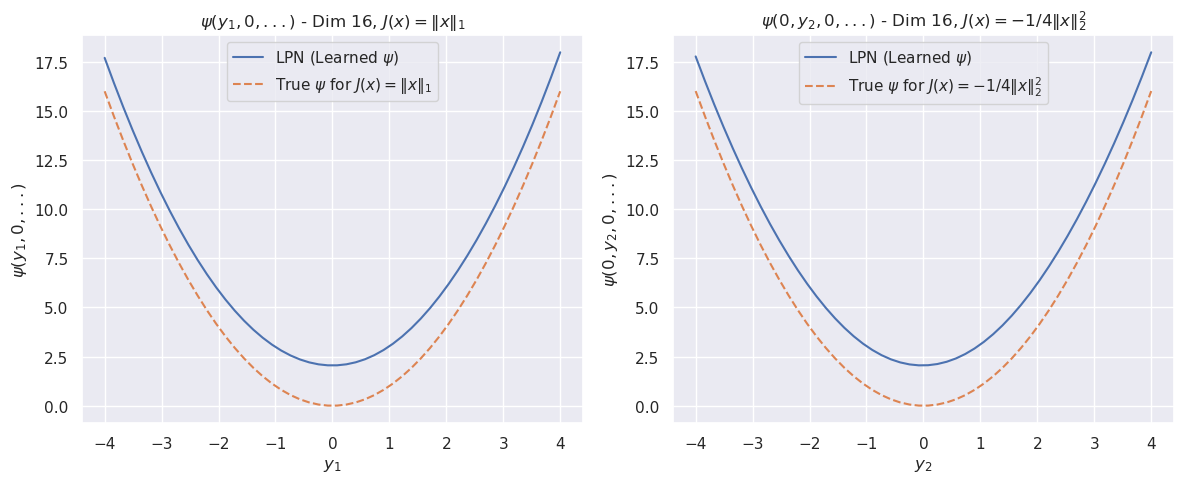

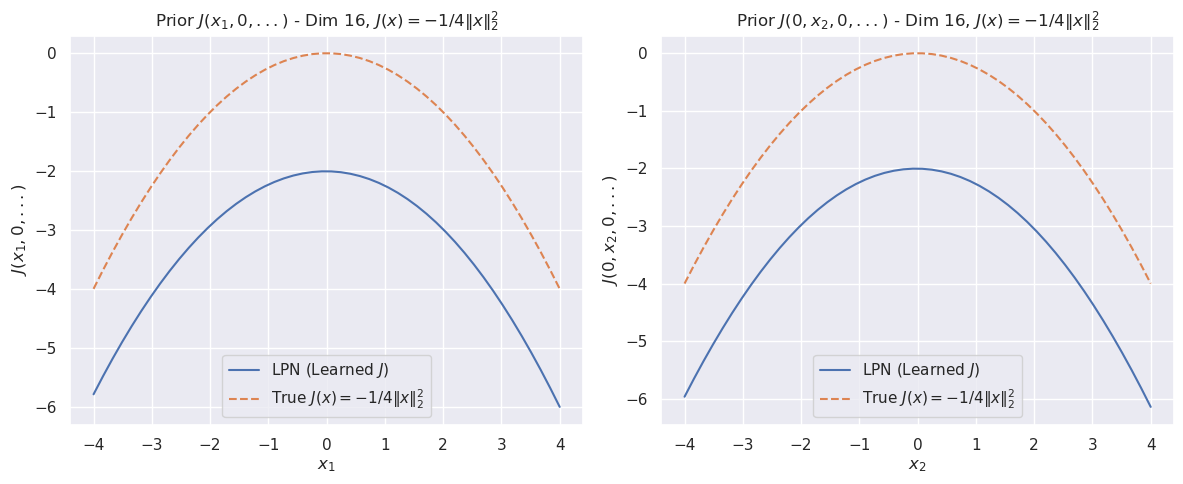

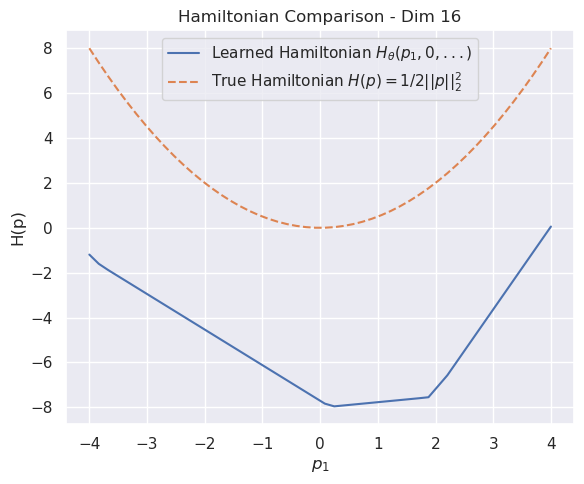

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


# def evaluate_updated_prior_J_hat(y_points, model, x_k_np):
#     """
#     Implements the approximate prior.
#     """
    
#     # Pre-compute y_k = grad psi(x_k) from the training data
#     x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
#     y_k_tensor = model(x_k_tensor)
#     y_k_np = y_k_tensor.detach().cpu().numpy()
    
#     # Compute S(x_k, 1) = psi(x_k, t=1) from the LPN
#     S_x_k = model.scalar(x_k_tensor)  # Shape (K, 1)
#     S_x_k_np = S_x_k.detach().cpu().numpy().flatten()  # Shape (K,)
    
#     # The constant term simplifies to just S(x_k, 1)
#     # Because: J_tilde(y_k) + 1/2||x_k - y_k||^2 
#     #        = [S(x_k,1) - 1/2||x_k - y_k||^2] + 1/2||x_k - y_k||^2 
#     #        = S(x_k, 1)
#     constants_k = S_x_k_np  # Shape (K,)
    
#     # Term 3: -1/2 * ||x_k - y||^2
#     # Broadcasting: x_k_np (K, 1, dim), y_points (1, N, dim) -> (K, N)
#     term3 = -0.5 * np.sum((x_k_np[:, np.newaxis, :] - y_points[np.newaxis, :, :])**2, axis=2)
    
#     # Term 4: 1/4 * ||y - y_k||^2
#     # Broadcasting: y_points (1, N, dim), y_k_np (K, 1, dim) -> (K, N)
#     term4 = 0.25 * np.sum((y_points[np.newaxis, :, :] - y_k_np[:, np.newaxis, :])**2, axis=2)

#     term5 = 0.5 * np.sum((x_k_np[:, np.newaxis, :])**2, axis=2)
#     all_terms = term5 - constants_k[:, np.newaxis] + term3 
    
#     # # Combine all terms: constants_k (K, 1) + term3 (K, N) + term4 (K, N)
#     # all_terms = constants_k[:, np.newaxis] + term3 + term4
    
#     # Take the max over K dimension
#     j_hat_est = np.max(all_terms, axis=0)
    
#     return j_hat_est

# def plot_updated_prior_J_hat(model, a, spacing, dim, x_k_np):
#     """
#     Generates cross-section plots for the prior j_hat(y) from the "Update".
#     """
#     print(f"\n--- Plotting Updated Prior j_hat(y) (Dim={dim}) ---")
#     xi, y1_0_points, y2_0_points = compute_square_cross_sections(a, spacing, dim)

#     # Compute true prior J(y)
#     y1_0_J_true = prior_true_concave_quad(y1_0_points)
    
#     # Compute estimated prior j_hat(y)
#     y1_0_J_hat_est = evaluate_updated_prior_J_hat(y1_0_points, model, x_k_np)

#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.plot(xi, y1_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#     plt.plot(xi, y1_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#     plt.grid(True)
#     plt.title(f"Updated Prior $\\hat{{J}}(y_1,0,...)$ - Dim {dim}")
#     plt.xlabel('$y_1$')
#     plt.ylabel('Prior Value')
#     plt.legend()

#     if dim > 1:
#         y2_0_J_true = prior_true_concave_quad(y2_0_points)
#         y2_0_J_hat_est = evaluate_updated_prior_J_hat(y2_0_points, model, x_k_np)
        
#         plt.subplot(1, 2, 2)
#         plt.plot(xi, y2_0_J_hat_est, "-", label="Approximate Prior $\\hat{J}(y)$")
#         plt.plot(xi, y2_0_J_true, "--", label="True Prior $J(y)=-1/4||y||_2^2$")
#         plt.grid(True)
#         plt.title(f"Updated Prior $\\hat{{J}}(0,y_2,0,...)$ - Dim {dim}")
#         plt.xlabel('$y_2$')
#         plt.ylabel('Prior Value')
#         plt.legend()
        
#     plt.tight_layout()
#     plt.show()


# # We use the original training data 'x_j_exp_np' as our set of x_k points.
# #subset_size = 1000 
# x_k_subset_np = y_j_exp_np#[:subset_size, :]

# plot_updated_prior_J_hat(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp, x_k_subset_np)


Generated G samples: G_samples_tensor shape torch.Size([30000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 7652.7490234375
iteration 0 loss 676.481689453125


iteration 500 loss 73.97608184814453


iteration 1000 loss 70.6982650756836


iteration 1500 loss 68.33826446533203


iteration 2000 loss 65.47384643554688


iteration 2500 loss 61.93019104003906


iteration 3000 loss 57.296600341796875


iteration 3500 loss 50.148223876953125


iteration 4000 loss 35.289493560791016


iteration 4500 loss 11.89102554321289


iteration 5000 loss 3.9881885051727295


iteration 5500 loss 2.664431095123291


iteration 6000 loss 2.1358797550201416


iteration 6500 loss 1.7340205907821655


iteration 7000 loss 1.4145443439483643


iteration 7500 loss 1.1609214544296265


iteration 8000 loss 1.0581382513046265


iteration 8500 loss 0.9887130260467529


iteration 9000 loss 0.9154161810874939


iteration 9500 loss 0.8378891944885254


iteration 10000 loss 0.7575691938400269


iteration 10500 loss 0.6770027279853821


iteration 11000 loss 9.9801607131958


iteration 11500 loss 0.5836372971534729


iteration 12000 loss 0.5635753273963928


iteration 12500 loss 0.5404208302497864


iteration 13000 loss 0.5134189128875732


iteration 13500 loss 0.4825158715248108


iteration 14000 loss 0.44808053970336914


iteration 14500 loss 0.4114968776702881


iteration 15000 loss 0.4017011225223541


iteration 15500 loss 0.39195817708969116


iteration 16000 loss 0.38082385063171387


iteration 16500 loss 0.36770570278167725


iteration 17000 loss 0.35235273838043213


iteration 17500 loss 0.3346606194972992


iteration 18000 loss 0.31516361236572266


iteration 18500 loss 0.3092629611492157


iteration 19000 loss 0.3022928833961487


iteration 19500 loss 0.2940842807292938


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.2843197286128998


iteration 20500 loss 0.28312158584594727


iteration 21000 loss 0.2816014885902405


iteration 21500 loss 0.27967920899391174


iteration 22000 loss 0.2772611975669861


iteration 22500 loss 0.27423593401908875


iteration 23000 loss 0.2704779803752899


iteration 23500 loss 0.2658520042896271


iteration 24000 loss 0.26022639870643616


iteration 24500 loss 0.2534829378128052


iteration 25000 loss 0.24551767110824585


iteration 25500 loss 0.23629479110240936


iteration 26000 loss 0.2297942340373993


iteration 26500 loss 0.2277483493089676


iteration 27000 loss 0.22522157430648804


iteration 27500 loss 0.22210827469825745


iteration 28000 loss 0.21829456090927124


iteration 28500 loss 0.2136746644973755


iteration 29000 loss 0.208145871758461


iteration 29500 loss 0.20165275037288666


iteration 30000 loss 0.1972523331642151


iteration 30500 loss 0.19515259563922882


iteration 31000 loss 0.19255785644054413


iteration 31500 loss 0.1893753856420517


iteration 32000 loss 0.1855163872241974


iteration 32500 loss 0.18091265857219696


iteration 33000 loss 0.17655737698078156


iteration 33500 loss 0.17552317678928375


iteration 34000 loss 0.1742604672908783


iteration 34500 loss 0.17268694937229156


iteration 35000 loss 0.17073588073253632


iteration 35500 loss 0.1683352142572403


iteration 36000 loss 0.16541029512882233


iteration 36500 loss 0.16188444197177887


iteration 37000 loss 0.1583082675933838


iteration 37500 loss 0.15738220512866974


iteration 38000 loss 0.1562448889017105


iteration 38500 loss 0.1548258513212204


iteration 39000 loss 0.15306390821933746


iteration 39500 loss 0.15089163184165955


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.14824137091636658


iteration 40500 loss 0.14791357517242432


iteration 41000 loss 0.14750252664089203


iteration 41500 loss 0.14698894321918488


iteration 42000 loss 0.1463533192873001


iteration 42500 loss 0.14557497203350067


iteration 43000 loss 0.14463408291339874


iteration 43500 loss 0.14351315796375275


iteration 44000 loss 0.1422034054994583


iteration 44500 loss 0.14070241153240204


iteration 45000 loss 0.13901598751544952


iteration 45500 loss 0.13716289401054382


iteration 46000 loss 0.13560299575328827


iteration 46500 loss 0.13391870260238647


iteration 47000 loss 0.1322835087776184


iteration 47500 loss 0.13064958155155182


iteration 48000 loss 0.12908712029457092


iteration 48500 loss 0.1276094913482666


iteration 49000 loss 0.12612347304821014


iteration 49500 loss 0.12475819140672684


iteration 50000 loss 0.1233685165643692


iteration 50500 loss 0.1220635399222374


iteration 51000 loss 0.12074200809001923


iteration 51500 loss 0.11946866661310196


iteration 52000 loss 0.1182374581694603


iteration 52500 loss 0.11700855195522308


iteration 53000 loss 0.11583450436592102


iteration 53500 loss 0.11463844776153564


iteration 54000 loss 0.11354129016399384


iteration 54500 loss 0.11238996684551239


iteration 55000 loss 0.11134838312864304


iteration 55500 loss 0.11024422198534012


iteration 56000 loss 0.10924588143825531


iteration 56500 loss 0.10818719863891602


iteration 57000 loss 0.10728614032268524


iteration 57500 loss 0.10634776949882507


iteration 58000 loss 0.10534858703613281


iteration 58500 loss 0.10445753484964371


iteration 59000 loss 0.10348615795373917


iteration 59500 loss 0.1026974469423294


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.10179948061704636


iteration 60500 loss 0.10169832408428192


iteration 61000 loss 0.10158427804708481


iteration 61500 loss 0.10145653039216995


iteration 62000 loss 0.10131658613681793


iteration 62500 loss 0.10116695612668991


iteration 63000 loss 0.10100952535867691


iteration 63500 loss 0.10084601491689682


iteration 64000 loss 0.10067799687385559


iteration 64500 loss 0.10050683468580246


iteration 65000 loss 0.10033382475376129


iteration 65500 loss 0.10015979409217834


iteration 66000 loss 0.09998530894517899


iteration 66500 loss 0.099810890853405


iteration 67000 loss 0.09963677078485489


iteration 67500 loss 0.0994633361697197


iteration 68000 loss 0.09929098933935165


iteration 68500 loss 0.09911970794200897


iteration 69000 loss 0.09894977509975433


iteration 69500 loss 0.09878093004226685


iteration 70000 loss 0.09861312061548233


iteration 70500 loss 0.098446324467659


iteration 71000 loss 0.09828047454357147


iteration 71500 loss 0.098115473985672


iteration 72000 loss 0.09795116633176804


iteration 72500 loss 0.09778758883476257


iteration 73000 loss 0.09762480854988098


iteration 73500 loss 0.09746270626783371


iteration 74000 loss 0.09730121493339539


iteration 74500 loss 0.09714043140411377


iteration 75000 loss 0.0969802588224411


iteration 75500 loss 0.09682076424360275


iteration 76000 loss 0.09666195511817932


iteration 76500 loss 0.09650371223688126


iteration 77000 loss 0.09634638577699661


iteration 77500 loss 0.09618953615427017


iteration 78000 loss 0.0960332527756691


iteration 78500 loss 0.09587769955396652


iteration 79000 loss 0.09572277218103409


iteration 79500 loss 0.09556857496500015


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.0954151377081871


iteration 80500 loss 0.09540058672428131


iteration 81000 loss 0.09538592398166656


iteration 81500 loss 0.0953712910413742


iteration 82000 loss 0.09535665810108185


iteration 82500 loss 0.09534186124801636


iteration 83000 loss 0.09532719850540161


iteration 83500 loss 0.09531241655349731


iteration 84000 loss 0.09529780596494675


iteration 84500 loss 0.09528307616710663


iteration 85000 loss 0.0952683687210083


iteration 85500 loss 0.09525371342897415


iteration 86000 loss 0.0952390506863594


iteration 86500 loss 0.09522438049316406


iteration 87000 loss 0.0952097475528717


iteration 87500 loss 0.09519509971141815


iteration 88000 loss 0.09518042951822281


iteration 88500 loss 0.09516581147909164


iteration 89000 loss 0.09515121579170227


iteration 89500 loss 0.09513663500547409


iteration 90000 loss 0.09512202441692352


iteration 90500 loss 0.09510739147663116


iteration 91000 loss 0.09509287029504776


iteration 91500 loss 0.09507831186056137


iteration 92000 loss 0.09506375342607498


iteration 92500 loss 0.09504915773868561


iteration 93000 loss 0.09503456950187683


iteration 93500 loss 0.0950201004743576


iteration 94000 loss 0.09500563144683838


iteration 94500 loss 0.09499111771583557


iteration 95000 loss 0.09497660398483276


iteration 95500 loss 0.09496207535266876


iteration 96000 loss 0.09494756907224655


iteration 96500 loss 0.09493309259414673


iteration 97000 loss 0.0949186161160469


iteration 97500 loss 0.09490415453910828


iteration 98000 loss 0.09488976001739502


iteration 98500 loss 0.09487529844045639


iteration 99000 loss 0.09486082941293716


iteration 99500 loss 0.09484641999006271


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


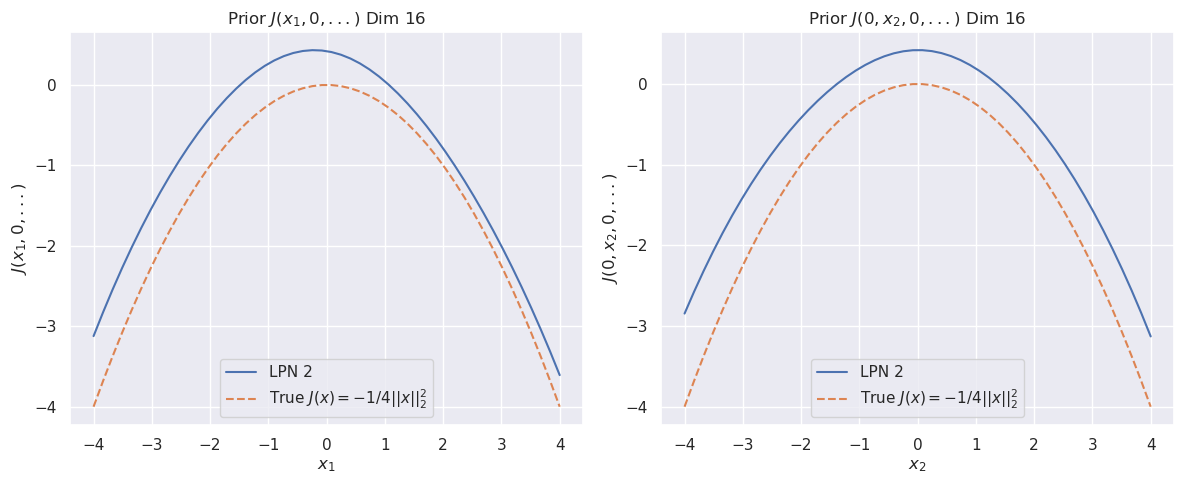

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)